In [1]:
import pandas as pd
import ast

from config import config
from notebook_utils import show_df
from dataloader import get_random_item, show_item, get_item
from augmentation import Augmentation
from aws.dynamodb import DynamoDBWrapper

### Json 파일 포맷

상품 json 파일에는 다양한 필드가 포함되어 있습니다. 그 중 필요한 필드만 선택적으로 사용하고자 합니다. 아래 값은 추출 예정인 json structure 입니다.

```
{id}.json
  └─ id (제품 ID)
  └─ price (제품 가격)
  └─ productDisplayName (제품 표시 이름)
  └─ variantName (유형 이름)
  └─ brandName (브랜드 이름)
  └─ ageGroup (연령대)
  └─ gender (성별)
  └─ fashionType (패션 유형)
  └─ season (시즌)
  └─ year (년도)
  └─ usage (사용 용도)
  └─ displayCategories (표시 카테고리)
  └─ styleImages (스타일 이미지)
       └─ default (기본 이미지)
            └─ imageURL (이미지 URL)
  └─ masterCategory (마스터 카테고리)
       └─ typeName (유형 이름)
  └─ subCategory (서브 카테고리)
       └─ typeName (유형 이름)
  └─ articleType (기사 유형)
       └─ typeName (유형 이름)
  └─ productDescriptors (제품 설명자)
       └─ description (설명)
            └─ descriptorType (설명 유형)
            └─ value (값)
```

`get_item()` 함수를 통해 필요한 필드만 추출해서 dict로 반환받을 수 있습니다.


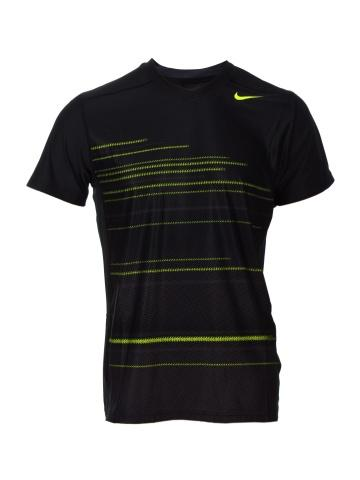

[10010] Nike Men As Showdown F Black T-Shirts


In [4]:
item = get_item('10010')
show_item(item)


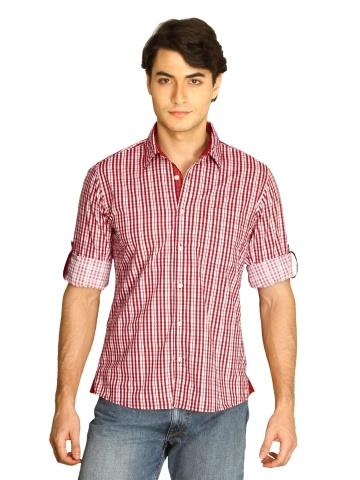

[9615] Indigo Nation Men Checks Red Shirts
{
    "id": "9615",
    "price": 154900,
    "productDisplayName": "Indigo Nation Men Checks Red Shirts",
    "variantName": "Checks Shirt",
    "brandName": "Indigo Nation",
    "ageGroup": "Adults-Men",
    "gender": "Men",
    "fashionType": "Fashion",
    "season": "Fall",
    "year": "2011",
    "usage": "Casual",
    "displayCategories": "Casual Wear",
    "thumbnail": "http://assets.myntassets.com/h_480,q_95,w_360/v1/images/style/properties/ff5d141307d0d5090eec8e2cd99bed5b_images.jpg",
    "styleImages_default": "http://assets.myntassets.com/v1/images/style/properties/ff5d141307d0d5090eec8e2cd99bed5b_images.jpg",
    "masterCategory": "Apparel",
    "subCategory": "Topwear",
    "articleType": "Shirts",
    "productDescriptors": "<p><strong>Composition</strong><br /> Red and white check shirt with light red accents, made of 100% cotton, has a tipped collar with red inseam, front buttoned placket with red inseam, full length sleeves with

In [4]:
item = get_random_item()
show_item(item, detail=True)

상품 정보는 위와 같이 JSON 형태로 표현될 수 있습니다. 이 데이터를 RAG 용 데이터로 활용하기에는 몇 가지 문제가 있습니다.

- **부족한 제품 설명**: 제품 설명(productDescriptors)에는 태그 값이 혼재되어 있을 뿐만 아니라, 주로 상품 설명보다는 주의 사항이나 관리 방법을 기술하고 있습니다. 이는 제품 자체의 특성을 설명하기에는 부족하여, 사용자가 원하는 제품 정보를 검색 하는 데 어려움을 겪을 수 있습니다.
- **JSON 포맷의 데이터**: Language Model은 일반적으로 자연어 텍스트로 학습이 되어 있어, JSON 구조에서는 필요한 정보를 효율적으로 추출하기 어려울 수 있습니다.

이를 해결하기 위해 아래와 같은 데이터 가공 작업을 수행합니다.

- 제품 이름과 관련된 모든 정보를 한국어로 번역하여, 사용자가 보다 쉽게 접근할 수 있도록 합니다.
- JSON 필드값과 상품 이미지를 기반으로, 제품의 주요 특성을 강조하는 설명 문구를 새롭게 작성합니다. 이를 통해 사용자에게 더 명확하고 유용한 정보를 제공할 수 있습니다.

---

## Prompt Engineering을 통해 상품 설명, 상품 태그 생성

Multimodal LLM 을 활용하여 상품에 대한 정보를 증강할 수 있습니다. 상품의 meta 정보를 포함하고 있는 JSON 데이터와 상품 이미지를 기반으로, 한국으로 된 상품 소개글과 태그를 생성할 수 있습니다.
Prompt Engineering 만으로도 필요한 내용에 대해 요청할 수 있고, 원하는 JSON Object 포맷으로 반환받을 수 있습니다. 증강된 데이터는 더욱 상세하게 상품에 대한 representation을 나타낼 수 있습니다.

- `namekor`: 제품 이름을 한국어로 표기
- `summary`: 제품 요약
- `image_summary`: 이미지 요약
- `tags`: 상품을 대표하는 태그
- `description`: 상품 소개 글

In [5]:
augmentation = Augmentation()

# 상품 소개 글 생성
desc = augmentation.gen_description(item)
print(desc)

# 상품 메타 정보 JSON 포맷으로 생성
metadata = augmentation.gen_properties(item)
print(metadata)

당신의 스타일을 한 단계 업그레이드할 수 있는 기회가 왔습니다! Indigo Nation의 새로운 체크 무늬 셔츠를 소개합니다. 이 셔츠는 빨간색과 하얀색의 세련된 조화로 당신의 캐주얼 룩에 스타일리시한 터치를 더해줄 것입니다. 

100% 코튼 소재로 제작되어 하루 종일 상쾌함을 유지하며, 팁드 칼라, 프론트 버튼 플라켓, 버튼 커프스 등 디테일이 가미되어 고급스러운 느낌을 자아냅니다. 레드 액센트 디자인이 더해져 전체적으로 생동감 있는 룩을 연출합니다.

이 셔츠는 데님, 코르덴, 정장 바지 등 다양한 하의와 매치할 수 있어 캐주얼부터 포멀까지 활용도가 높습니다. 블랙 구두를 신으면 더욱 스타일리시한 모습을 연출할 수 있습니다. 

Indigo Nation의 체크 무늬 셔츠로 당신의 패션 센스를 한층 업그레이드하세요. 주위의 시선을 한 몸에 받을 준비가 되셨나요?
{'namekor': '인디고 네이션 남성 체크 무늬 레드 셔츠', 'summary': '이 제품은 캐주얼하고 스타일리시한 체크 무늬 셔츠로 보입니다.', 'image_summary': '이미지는 빨간색과 흰색 체크 무늬 패턴의 긴팔 셔츠를 착용한 남성 모델을 보여주고 있습니다. 셔츠는 면 소재로 만들어졌으며 칼라, 프론트 플라켓, 커프스, 포켓 등의 디테일이 있습니다.', 'tags': ['체크 무늬', '레드', '화이트', '코튼', '캐주얼웨어', '긴팔', '남성복']}


---

## Augment 된 데이터 CSV 파일로 저장
- 아래 작업을 통해 생성된 샘플 데이터가 `data/product.csv`에 위치해 있습니다. 샘플 데이터를 사용하실 분은 아래 작업을 수행하지 않으셔도 됩니다.
- csv 파일로 생성하는 것은 추후 Bedrock Knowledge Base에 업로드하여 테스트하기 위함입니다. Knowlege Base를 사용하지 않는 경우 바로 DynamoDB로 업로드 하시면 됩니다.

In [2]:
CSV_PATH = '../data/product.csv'
MAX_ITEM = 100

def augment_item(item):
    augmentation = Augmentation()
    desc = augmentation.gen_description(item)
    metadata = augmentation.gen_properties(item)
    item.update({
        'description': desc,
        **metadata,
    })
    return item

In [14]:
# 랜덤한 {MAX_ITEM}개의 아이템을 augmentation 후, {CSV_PATH}에 저장

df = pd.DataFrame()
for idx in range(MAX_ITEM):
    try:
        item = get_random_item()        
        augmentedItem = augment_item(item)
        df = pd.concat([df, pd.DataFrame([augmentedItem])], ignore_index=True)
    except Exception as e:
        print(e)

df.to_csv(CSV_PATH, index=False, encoding='utf-8')

id,thumbnail,description,namekor,summary,tags
39194,,"여성 여러분, 이번 시즌 가장 핫한 신발 트렌드를 만나보세요! 캣워크의 새로운 실버 하이힐은 당신의 스타일을 완벽하게 업그레이드해줄 것입니다.\n\n이 샌들은 우아한 디자인과 세련된 광택으로 모든 옷차림에 잘 어울립니다. 정장 차림에도, 캐주얼 룩에도 완벽한 매치가 되죠. 발가락 사이로 스쳐지나가는 스팽글 장식 스트랩이 발걸음마다 반짝이는 멋진 하이힐입니다. \n\n3인치 웨지 힐은 착용감이 편안하면서도 다리라인을 슬림하게 연출해줍니다. 발바닥 쿠션과 미끄럼 방지 밑창으로 하루 종일 걸어다녀도 피로감이 없답니다.\n\n이번 겨울, 캣워크 실버 하이힐로 당신만의 독특한 스타일을 완성해보세요. 반짝이는 멋진 디자인에 빠져들 것입니다!",캣워크 여성 실버 하이힐,"여성용 실버 색상의 하이힐 샌들로, 스팽글 장식과 웨지 굽이 특징입니다.","['실버', '웨지힐', '오픈토', '스팽글', '스트랩', '합성소재']"
53589,,"시간을 멋지게 차려입힌 Q&Q 남성 블랙 다이얼 시계를 소개합니다. 이 시계는 스테인리스 스틸 라운드 케이스와 블랙 다이얼, 블랙과 화이트 핸즈로 이루어져 있어 세련되고 모던한 느낌을 줍니다. 스틸 스트랩과 버터플라이 클래스프로 편안하게 착용할 수 있죠. 5BAR 방수 기능이 있어 일상생활에서 안심하고 착용할 수 있습니다. \n\n이 시계는 단순한 시간 확인 기능을 넘어 당신의 스타일을 한층 업그레이드시켜 줄 것입니다. 캐주얼한 옷차림에 포인트를 주거나 정장 차림에 잘 어울리는 멋진 액세서리가 되어줄 것입니다. 1년 품질 보증으로 안심하고 구매할 수 있습니다. 지금 바로 Q&Q 남성 블랙 다이얼 시계를 겟하세요!",Q&Q 남성 블랙 다이얼 시계,"스테인리스 스틸 케이스와 블랙 다이얼, 스틸 스트랩으로 이루어진 Q&Q 브랜드의 남성용 캐주얼 시계입니다.","['스테인리스스틸', '블랙', '화이트', '노란색', '아날로그', '남성', '캐주얼', '방수']"
8242,,축구화 마니아들을 위한 혁신적인 속도의 신발이 여기 있습니다! 나이키 머큐리얼 빅토리 II는 경기장에서 가장 빠른 선수가 되고 싶은 분들을 위해 특별히 설계되었습니다. 부드러운 합성 가죽 소재로 만들어져 뛰어난 볼 터치감과 제어력을 자랑합니다. TPU 블레이드 스터드가 가속력과 트랙션을 최적화해 줍니다. 이 신발을 신고 수비수들을 따돌리며 골대를 향해 질주하세요. \n\n가벼운 무게와 인체공학적 디자인으로 발에 꼭 맞는 착용감을 선사합니다. 미드솔의 EVA 인솔과 TPU 플레이트가 충격을 완벽히 흡수해 줍니다. 아웃솔의 다방향 스터드 패턴은 순간적인 가속과 방향 전환에 탁월한 기능을 발휘합니다. 이 신발 한 켤레로 그라운드를 화염처럼 달리세요! 나이키 머큐리얼 빅토리 II가 당신의 스피드 게임을 완성해 줄 것입니다.,나이키 남성 머큐리얼 빅토리 II 레드 신발,"이 신발은 경량 나이키 머큐리얼 빅토리 축구화로, 하드 코트에서 플레이하기에 적합하게 디자인되었습니다.","['보라색', '축구화', '나이키', '경량', '스터드', '유연한 디자인']"
6688,,"여성 여러분, 이번 여름 스타일리시한 모습으로 돋보이세요! 유나이티드 컬러스 오브 베네통의 블랙 V넥 티셔츠를 소개합니다. 이 티셔츠는 100% 순면으로 제작되어 부드럽고 통기성이 좋아 더운 날씨에도 쾌적한 착용감을 선사합니다. \n\n단정하면서도 세련된 V넥 디자인과 베네통 특유의 빅벤 로고가 가슴팍에 스와로브스키 크리스털로 장식되어 있어 고급스러운 분위기를 자아냅니다. 이 티셔츠 하나만으로도 당신의 스타일을 한층 업그레이드시켜 줄 것입니다.\n\n데님에 깔끔하게 매치하거나 캐주얼한 바텀스와 함께 입으면 편안하면서도 트렌디한 룩을 연출할 수 있습니다. 이번 시즌 유나이티드 컬러스 오브 베네통의 블랙 V넥 티셔츠로 당신만의 스타일을 완성해보세요!",유나이티드 컬러스 오브 베네통 여성 V넥 블랙 티셔츠,베네통 브랜드의 여성용 캐주얼 V넥 반팔 블랙 티셔츠입니다.,"['블랙', 'V넥', '반팔', '코튼', '캐주얼', '여성복', '티셔츠', '크리스털 장식']"
44816,,"여성을 위한 스파이커의 블루 진, 당신의 캐주얼 스타일을 완성하세요!\n\n청바지는 우리 옷장의 필수품입니다. 스파이커의 이 블루 진은 여유로운 착용감과 세련된 디자인으로 당신의 일상 룩을 한층 업그레이드해 줄 것입니다. 부드러운 워싱 효과로 винтаж한 느낌을 자아내며, 앞면의 지퍼와 버튼 디테일이 실용성을 더해줍니다. \n\n양쪽 힙 부분에 패치 포켓이 있어 작은 소지품을 간편하게 넣을 수 있고, 뒷면 포켓에는 브랜드 로고 자수가 포인트를 줍니다. 허리 벨트 고리가 있어 벨트를 매치하면 개성 있는 스타일을 연출할 수 있습니다.\n\n이 청바지 하나로 데님 룩을 완성할 수 있습니다. 캐주얼한 티셔츠나 블라우스를 매치해 편안하면서도 스타일리시한 데일리 룩을 완성해보세요. 여름 시즌 내내 활용할 수 있는 스파이커 청바지를 지금 만나보세요!",스파이커 여성 블루 진,편안한 착용감과 캐주얼한 스타일의 여성용 블루 데님 진바지입니다.,"['블루', '데님', '스트레이트 핏', '캐주얼', '여성용', '진바지', '지퍼', '단추']"

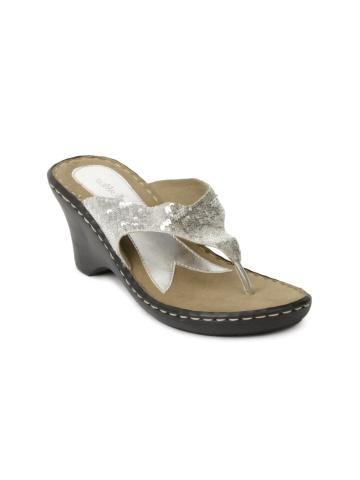
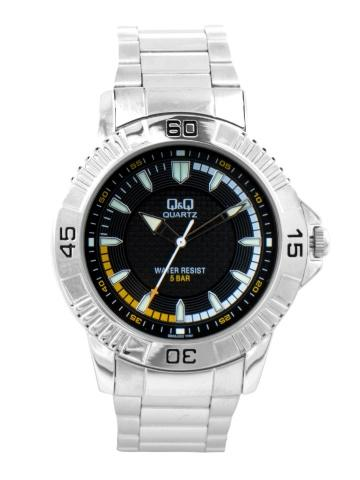
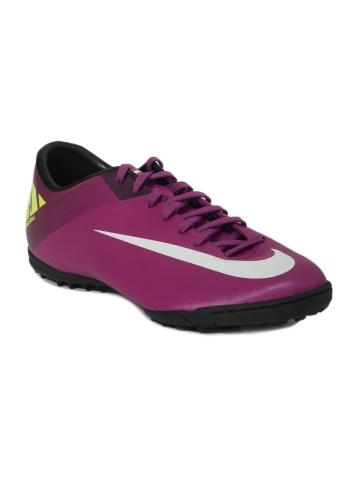
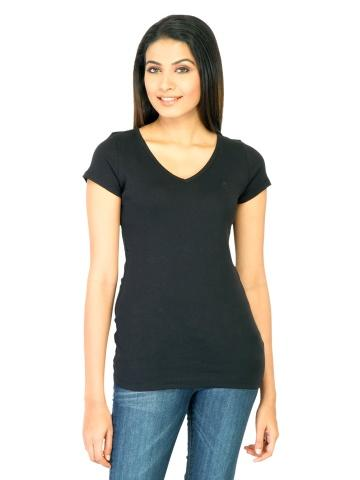
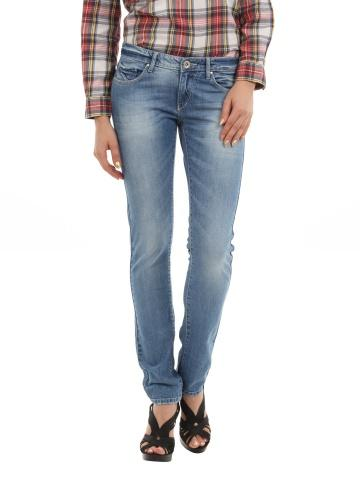

In [17]:
# 생성된 데이터 확인
df = pd.read_csv(CSV_PATH, usecols=['id', 'thumbnail', 'namekor', 'summary', 'description', 'tags'])[:5]
show_df(df)

---

## 생성된 데이터 DynamoDB에 저장

사용자에게 표출할 아이템의 metadata를 DynamoDB에 저장합니다.
- Partition Key가 `id (string)`인 DynamoDB 테이블이 생성되어 있어야 합니다.

In [ ]:
# {CSV_PATH}의 아이템을 DynamoDB 테이블에 저장
db = DynamoDBWrapper(table_name=config.DYNAMODB_TABLE)

df = pd.read_csv(CSV_PATH, dtype={'id': str}, na_values=['nan', 'NaN'], keep_default_na=False)
for index, row in df.iterrows():
    row_dict = row.to_dict()
    row_dict['tags'] = ast.literal_eval(row_dict['tags'])
    db.put_item(row_dict)

id,thumbnail,namekor,summary,description,tags
9134,,푸마 남성 이크노이스 2XT 블랙 스포츠 신발,이 제품은 메쉬 소재와 합성 오버레이가 있는 블랙 컬러의 스포츠 신발입니다.,"당신의 활동적인 라이프스타일에 맞춘 퓨마의 아이코닉한 스포츠 슈즈를 소개합니다. 아이크노이스 2XT 블랙 슈즈는 편안함과 성능을 모두 잡았습니다. 이 신발은 당신이 달리는 동안 최상의 쿠셔닝과 안정감을 제공하며, 스타일리시한 디자인까지 겸비했습니다.\n\n통기성 높은 메쉬 업퍼와 합성 오버레이가 안정감 있는 착화감을 선사합니다. 퓨마 고유의 폼스트라이프와 캐트 로고가 스타일리시한 포인트를 더해줍니다. 부드러운 EVA 미드솔과 OrthoLite 인솔은 최상의 쿠셔닝과 충격 흡수력을 자랑합니다. \n\n아웃솔의 아치텍 기술은 착지에서 발가락 까지 자연스러운 움직임을 도와줍니다. 셀 유닛과 에버트랙 아웃솔은 내구성이 뛰어나 오래 신어도 편안합니다. 유연한 플렉스 그루브 패턴은 활동성을 높여줍니다. \n\n이제 퓨마 아이크노이스 2XT 슈즈와 함께 활력 넘치는 라이프스타일을 즐겨보세요!","[블랙, 메쉬, 스포츠, 남성, 런닝화, 푸마, 통기성, 쿠셔닝]"
9957,,나이키 남성 아스널 오쎈틱 화이트 티셔츠,"이 제품은 흰색 면 소재의 반팔 티셔츠로, 가슴 부분에 그래픽 프린트가 있고 왼쪽 소매에 나이키 로고가 새겨져 있습니다.",아스날 팬들을 위한 필수 아이템! 나이키의 새로운 아스날 오쓰덴틱 티셔츠를 소개합니다.\n\n이 티셔츠는 100% 순면으로 제작되어 부드럽고 편안한 착용감을 선사합니다. 화이트 컬러에 아스날의 상징적인 그래픽이 프린트되어 있어 시선을 사로잡습니다. 팀의 열정과 자부심을 상징하는 이 티셔츠는 경기장에서나 일상에서 활력 넘치는 스타일을 완성해줄 것입니다.\n\n나이키 로고가 새겨진 소매 디테일과 목 라인의 테이프 마감 등 섬세한 디자인이 더해져 고급스러움을 더했습니다. 정교한 그래픽 작업과 프리미엄 소재가 만나 탄생한 이 티셔츠는 팬들의 마음을 사로잡을 것입니다.\n\n지금 바로 나이키 아스날 오쓰덴틱 티셔츠를 겟하세요! 팀 사랑과 스타일을 동시에 만족시킬 수 있는 기회를 잡으세요.,"[화이트, 반팔, 면, 그래픽프린트, 나이키로고, 단순디자인]"
43239,,리복 남성 화이트 스위프트 스포츠 신발,이 제품은 메쉬 소재의 화이트 컬러 스포츠 신발로 보입니다.,"활기찬 스포츠 라이프를 위한 리복의 Swift 스포츠화\n\n여러분, 스포츠와 활동적인 라이프스타일을 사랑하는 분들을 위한 완벽한 제품을 소개합니다. 리복의 Swift 스포츠화는 메쉬 소재와 합성 오버레이로 견고한 구조를 자랑하며, 중앙 레이스업 디자인과 메쉬 패딩 안감으로 편안한 착화감을 선사합니다. \n\nLiteRide 인솔은 부드러운 쿠셔닝을 제공하고, 두꺼운 폼 아웃솔에는 너브와 홈이 있어 탁월한 그립력을 발휘합니다. 발등 부분의 아치형 디자인 역시 안정감 있는 착화감을 더해줍니다. \n\n이번 여름, 활력 넘치는 스포츠 라이프를 위해 리복 Swift 스포츠화와 함께 하세요. 스타일리시한 디자인과 탁월한 기능성으로 당신의 액티브한 라이프스타일을 완벽하게 보조해 줄 것입니다.","[화이트, 메쉬, 스포츠, 런닝화, 레드 포인트, 고무 밑창]"

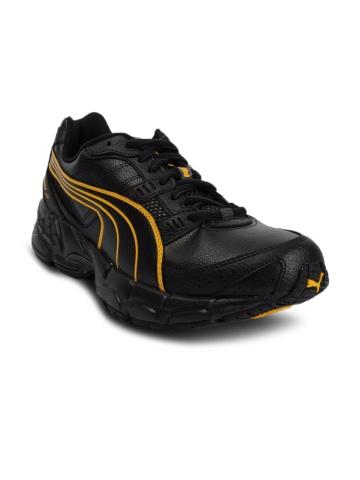
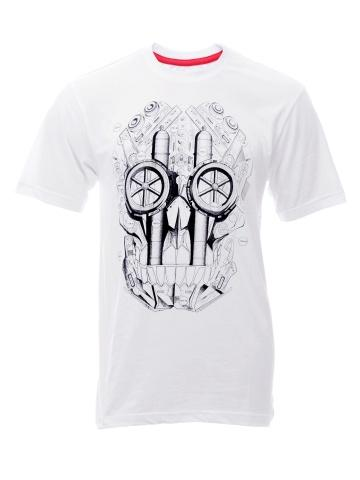
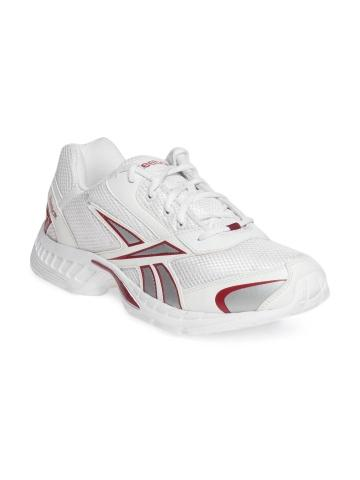

In [5]:
# DynamoDB에 저장된 데이터 확인

items = db.query({
    'Limit': 3
}).get('Items', [])

df = pd.DataFrame(items, columns=['id', 'thumbnail', 'namekor', 'summary', 'description', 'tags'])
show_df(df)